# Import Library

In [ ]:
import wget
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset

In [ ]:
wget.download("https://drive.google.com/uc?export=download&id=1IMCE-y6zrE8j4ZE-JwlElN5bhQ8xf_Kf", "dataset.zip")

'dataset (3).zip'

In [3]:
zip_path = "dataset.zip"   
extract_to = "./"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Selesai extract ke:", extract_to)

Selesai extract ke: ./


In [4]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None
    
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image, gray

# Feature Extraction

In [5]:
from skimage.feature import local_binary_pattern
import numpy as np

# LBP parameters
LBP_POINTS = 24       # number of sampling points
LBP_RADIUS = 3        # radius of circle

def extract_lbp_features(image_gray):
    """
    Extract LBP features from a grayscale image (already resized).
    Output: feature vector (flattened histogram) + LBP map.
    """
    # Compute LBP map
    lbp_map = local_binary_pattern(
        image_gray,
        P=LBP_POINTS,
        R=LBP_RADIUS,
        method="uniform"
    )

    # Compute histogram as feature vector
    n_bins = LBP_POINTS + 2  # uniform patterns
    hist, _ = np.histogram(
        lbp_map.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )

    return hist, lbp_map

# Pre-processing Dataset

In [6]:
def crop_half_image(img, bottom=True):
    """
    Mengembalikan crop separuh bawah (bottom=True) atau separuh atas (bottom=False)
    img: grayscale atau BGR numpy array
    """
    h = img.shape[0]
    mid = h // 2
    if bottom:
        cropped = img[mid:, :]
    else:
        cropped = img[:mid, :]
    return cropped

In [9]:
dataset_dir = 'dataset/'
IMAGE_SIZE = (64,64)
X = []
y = []
lbp_img =[]

for root, dirs, files in os.walk(dataset_dir):
    print(root, dirs, files)
    for f in files:
        _, image_gray = load_image(os.path.join(root, f))
        img_crop = crop_half_image(image_gray, bottom=True)
        # jika crop menghasilkan area kosong atau sangat kecil, fallback ke citra penuh
        if img_crop is None or img_crop.size == 0 or img_crop.shape[0] < 4 or img_crop.shape[1] < 4:
            img_crop = image_gray  # fallback
            # optional: print warning
            print(f"[WARN] Crop menghasilkan area kecil untuk {files}, menggunakan citra penuh.")
        
        roi_resized = cv2.resize(img_crop, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # type: ignore
        lbp_feature, lbp_maps = extract_lbp_features(roi_resized)
        if lbp_feature is None:
            continue
        
        lbp_img.append(lbp_maps)
        X.append(lbp_feature)
        
        if root.split('/')[-1]=="without_mask":
            y.append(0)
        
        else:
            y.append(1)

X = np.array(X)
y = np.array(y)

print(f"[INFO] Total sampel fitur: {X.shape[0]}, dimensi fitur: {X.shape[1]}")

dataset/ ['without_mask', 'with_mask'] []
dataset/without_mask [] ['0_0_aidai_0014.jpg', '0_0_aidai_0029.jpg', '0_0_aidai_0043.jpg', '0_0_aidai_0074.jpg', '0_0_aidai_0084.jpg', '0_0_aidai_0136.jpg', '0_0_anhu_0004.jpg', '0_0_anhu_0020.jpg', '0_0_anhu_0025.jpg', '0_0_anhu_0027.jpg', '0_0_anhu_0056.jpg', '0_0_anhu_0057.jpg', '0_0_anhu_0062.jpg', '0_0_anhu_0063.jpg', '0_0_anhu_0098.jpg', '0_0_anhu_0103.jpg', '0_0_anhu_0155.jpg', '0_0_anhu_0157.jpg', '0_0_anhu_0189.jpg', '0_0_anhu_0201.jpg', '0_0_anhu_0205.jpg', '0_0_anhu_0209.jpg', '0_0_anhu_0211.jpg', '0_0_anhu_0214.jpg', '0_0_anhu_0216.jpg', '0_0_baibaihe_0077.jpg', '0_0_baibaihe_0085.jpg', '0_0_baibaihe_0093.jpg', '0_0_baibaihe_0204.jpg', '0_0_baibaihe_0216.jpg', '0_0_baibaihe_0236.jpg', '0_0_baobeier_0014.jpg', '0_0_baobeier_0016.jpg', '0_0_baobeier_0020.jpg', '0_0_baobeier_0046.jpg', '0_0_baobeier_0062.jpg', '0_0_baobeier_0064.jpg', '0_0_baobeier_0098.jpg', '0_0_baobeier_0099.jpg', '0_0_baobeier_0140.jpg', '0_0_benxi_0054.jpg', '0_0_

# Visualisasi Features

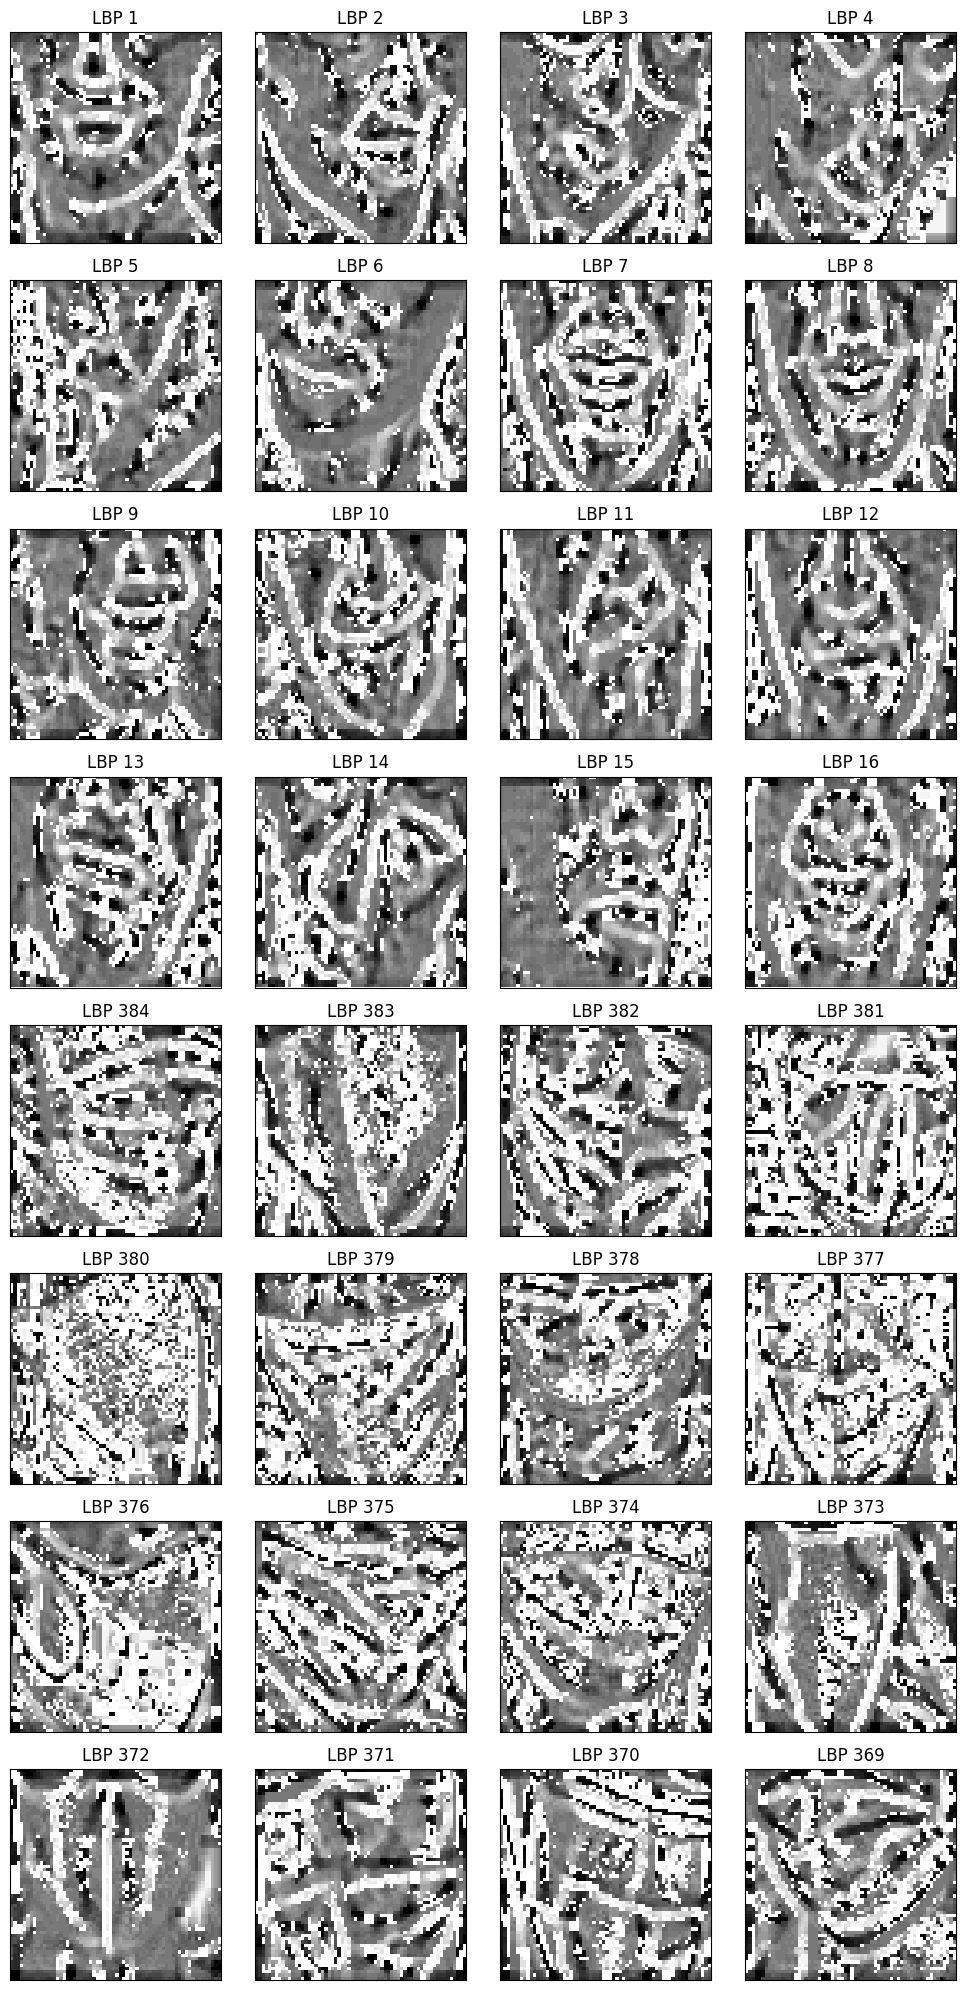

In [11]:
from skimage import exposure

ncol = 4
nrow = 8
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    if i < 16:
        temp =lbp_img[i]
        lbp_image = exposure.rescale_intensity(temp, in_range=(0, temp.max()))
        ax.imshow(lbp_image, cmap='gray')
        ax.set_title(f'LBP {i+1}')
    else:
        temp =lbp_img[len(lbp_img) - (i)]
        lbp_image = exposure.rescale_intensity(temp, in_range=(0, temp.max()))
        ax.imshow(lbp_image, cmap='gray')
        ax.set_title(f'LBP {len(lbp_img) - (i)}')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y )

# Training Process

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# scale fitur
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# training SVM (RBF)
clf = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
print("[INFO] Training SVM...")
clf.fit(X_train_s, y_train)

# evaluasi
y_pred = clf.predict(X_test_s)
print("\n[RESULT] Classification report:")
print(classification_report(y_test, y_pred, target_names=["without_mask","with_mask"]))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


[INFO] Training SVM...

[RESULT] Classification report:
              precision    recall  f1-score   support

without_mask       0.93      0.93      0.93        40
   with_mask       0.93      0.93      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.93        80
weighted avg       0.93      0.93      0.93        80

Confusion matrix:
[[37  3]
 [ 3 37]]


In [14]:
import joblib

MODEL_PATH = "svm_mask_200_bottom_half.pkl"

# save model + scaler
joblib.dump({
    "model": clf,
    "scaler": scaler,
    "config": {
        "image_size": IMAGE_SIZE,
        "lbp_params": {
            "points": LBP_POINTS,
            "radius": LBP_RADIUS,
            "method": "uniform"
        },
        "crop": "bottom"
    }
}, MODEL_PATH)

print(f"[INFO] Model tersimpan di: {MODEL_PATH}")

[INFO] Model tersimpan di: svm_mask_200_bottom_half.pkl


# Test Single Image

## 1. Face Detection

In [15]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [16]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
  )
    return faces

In [17]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])
    
    return cropped_faces, selected_faces

## 2. Feture Extraction

In [18]:
def feature_extraction_for_test(image_gray):

    features, lbp_maps = [],[]

    faces = detect_faces(image_gray)

    cropped_face, _ = crop_faces(image_gray, faces)

    if cropped_face is None:
        print("wajah tidak terdeteksi..")
        return features, lbp_maps 
    else:

        img_crop = crop_half_image(cropped_face[0], bottom=True)

        # jika crop menghasilkan area kosong atau sangat kecil, fallback ke citra penuh
        if img_crop is None or img_crop.size == 0 or img_crop.shape[0] < 4 or img_crop.shape[1] < 4:
            img_crop = cropped_face[0]  # fallback
            # optional: print warning
            print(f"[WARN] Crop menghasilkan area kecil untuk {files}, menggunakan citra penuh.")

        roi_resized = cv2.resize(img_crop, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # type: ignore

        features, lbp_maps = extract_lbp_features(roi_resized)
        features = np.array(features)       
        features = features.reshape(1, -1)  
        return features, lbp_maps 

## 3. Prediction Process

In [19]:
import joblib

def predict_image(image, features, model_path):

    data = joblib.load(model_path)
    model_loaded = data.get("model")
    scaler = data.get("scaler")

    if scaler is not None:
        features = scaler.transform(features)
    pred = model_loaded.predict(features)[0]
    conf = None
    prob = 0
    prob = model_loaded.predict_proba(features)[0] if hasattr(model_loaded, "predict_proba") else None
    conf = float(max(prob))

    if pred == 1:
        label_str = "MASK"
    else:
        label_str = "NO MASK"

    print(f"Prediksi: {label_str}")

    return draw_result(image, conf, label_str)

def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(10, 30),             
              font_scale=0.6,
              font_thickness=2,
              text_color=(255, 255, 255),
              text_color_bg=(0, 0, 255)
              ):
    x, y = pos
    score_text = f'Score: {score:.2f}'
    
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label,      font, font_scale, font_thickness)
    
    box_width  = max(w1, w2) + 20
    box_height = h1 + h2 + 25

    # pastikan tidak keluar dari gambar (opsional)
    x = max(0, x)
    y = max(box_height, y)

    # background kotak
    cv2.rectangle(image,
                  (x, y - box_height),
                  (x + box_width, y),
                  text_color_bg,
                  -1)

    # tulis label
    cv2.putText(image, label, (x + 10, y - h1 - 10),
                font, font_scale, text_color, font_thickness)

    # tulis score
    cv2.putText(image, score_text, (x + 10, y - 10),
                font, font_scale, text_color, font_thickness)


def draw_result(image_bgr, score, label):
    """
    image_bgr : citra BGR (OpenCV)
    score     : float
    label     : string
    return    : citra BGR yang sudah diberi teks
    """
    result_image = image_bgr.copy()
    draw_text(result_image, label, score, pos=(10, 40))
    return result_image


Prediksi: MASK


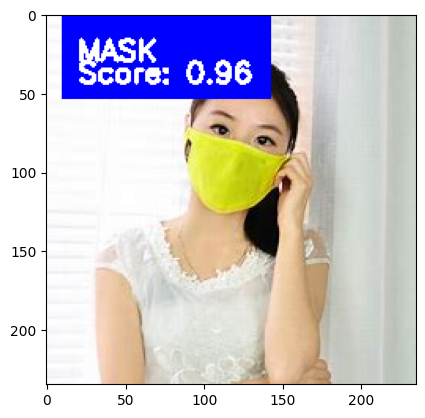

In [20]:
TESTING_IMAGE = "testing/mask1.png"

lbp_feature, lbp_maps = [],[]
image_rgb, image_gray = load_image(TESTING_IMAGE)

lbp_feature, lbp_image = feature_extraction_for_test(image_gray)

result_image = predict_image(image_rgb, lbp_feature, MODEL_PATH)

plt.imshow(result_image)


Prediksi: MASK


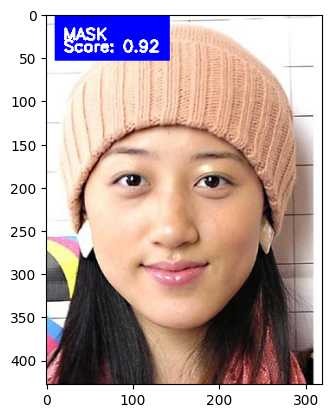

In [21]:
TESTING_IMAGE = "testing/1.jpg"

lbp_feature, lbp_maps = [],[]
image_rgb, image_gray = load_image(TESTING_IMAGE)

lbp_feature, lbp_maps = feature_extraction_for_test(image_gray)

result_image = predict_image(image_rgb, lbp_feature, MODEL_PATH)

plt.imshow(result_image)


In [24]:
from skimage.feature import local_binary_pattern
import numpy as np

def extract_lbp(img):
    # compute LBP map
    lbp = local_binary_pattern(
        img,
        P=LBP_PARAMS["points"],
        R=LBP_PARAMS["radius"],
        method=LBP_PARAMS["method"]
    )

    # histogram as feature vector
    n_bins = LBP_PARAMS["points"] + 2  # for "uniform"
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )

    return hist.reshape(1, -1)


def predict_from_roi(roi_gray):
    roi = cv2.resize(roi_gray, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    feat = extract_lbp(roi)

    if scaler is not None:
        feat = scaler.transform(feat)

    pred = model.predict(feat)[0]

    conf = None
    if hasattr(model, "predict_proba"):
        conf = float(max(model.predict_proba(feat)[0]))

    return pred, conf


In [23]:
data = joblib.load(MODEL_FILE)
model = data.get("model")
scaler = data.get("scaler")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + FACE_CASCADE)
nose_cascade = cv2.CascadeClassifier(NOSE_CASCADE)

NameError: name 'MODEL_FILE' is not defined

In [ ]:
from skimage.feature import local_binary_pattern
import numpy as np

def extract_lbp(img):
    # compute LBP map
    lbp = local_binary_pattern(
        img,
        P=LBP_PARAMS["points"],
        R=LBP_PARAMS["radius"],
        method=LBP_PARAMS["method"]
    )

    # histogram as feature vector
    n_bins = LBP_PARAMS["points"] + 2  # for "uniform"
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )

    return hist.reshape(1, -1)


def predict_from_roi(roi_gray):
    roi = cv2.resize(roi_gray, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    feat = extract_lbp(roi)

    if scaler is not None:
        feat = scaler.transform(feat)

    pred = model.predict(feat)[0]

    conf = None
    if hasattr(model, "predict_proba"):
        conf = float(max(model.predict_proba(feat)[0]))

    return pred, conf


In [22]:
cap = cv2.VideoCapture(0)

while True:
  ret, frame = cap.read()
  if not ret:
    print("Break")
    break

  if frame.shape[1] > 1280:
    scale = 1280 / frame.shape[1]
    frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(60,60))

  for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]

    ny1 = int(h * 0.35); ny2 = int(h * 0.90)
    roi_nose = roi_gray[ny1:ny2, :]

    noses = nose_cascade.detectMultiScale(roi_nose, scaleFactor=1.1,
    minNeighbors=4, minSize=(20,20))

    half = h // 2
    roi_bottom = roi_gray[half:h, :]
    use_roi = roi_bottom if roi_bottom.size >= 64 else (roi_nose if roi_nose.size >= 64 else roi_gray)

    if len(noses) > 0:
      label = "NO MASK"
      color = (0,0,255)
      #for (nx, ny, nw, nh) in noses:
        #cv2.rectangle(roi_color, (nx, ny+ny1), (nx+nw, ny+ny1+nh), color, 1)
    else:
      pred, conf = predict_from_roi(use_roi)
      if pred == 1:
        label, color = "MASK", (0,255,0)
      else:
        label, color = "NO MASK", (0,0,255)
      if conf is not None:
        cv2.putText(frame, f"{conf:.2f}", (x, y+h+18), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2.rectangle(frame, (x, y), (x + w, y+ h), color, 2)
    cv2.putText(frame, label, (x, max(20, y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

  cv2.imshow("Mask Detection", frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
      break

cap.release()
cv2.destroyAllWindows()

In [23]:
for (x,y,w,h) in faces:
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = frame[y:y+h, x:x+w]
  ny1 = int(h * 0.35); ny2 = int(h * 0.90)
  roi_nose = roi_gray[ny1:ny2, :]
  noses = nose_cascade.detectMultiScale(roi_nose, scaleFactor=1.1,
  minNeighbors=4, minSize=(20,20))
  half = h // 2
  roi_bottom = roi_gray[half:h, :]
  use_roi = roi_bottom if roi_bottom.size >= 64 else (roi_nose if roi_nose.size
  >= 64 else roi_gray)


In [ ]:
if len(noses) > 0:
  label = "NO MASK"
  color = (0,0,255)
  for (nx, ny, nw, nh) in noses:
  cv2.rectangle(roi_color, (nx, ny+ny1), (nx+nw, ny+ny1+nh), color, 1)
else:
  pred, conf = predict_from_roi(use_roi)
  if pred == 1:
    label, color = "MASK", (0,255,0)
  else:
    label, color = "NO MASK", (0,0,255)
  if conf is not None:
    cv2.putText(frame, f"{conf:.2f}", (x, y+h+18), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
  color, 2)


IndentationError: expected an indented block after 'for' statement on line 4 (3446782391.py, line 5)